In [2]:
import numpy as np  # as always import the nesscary packages / libraries. 
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
class DataTransform: # use the DataTransfrom class change to the right dtypes form the .csv df. 
    def __init__(self, df):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Input must be a Pandas DataFrame.")
        self.df = df

    def change_dtypes(self, dtype_dict):
        try:
            for column, dtype in dtype_dict.items():
                if column in self.df.columns:
                    if dtype == "datetime64":
                        self.df[column] = pd.to_datetime(self.df[column], errors='coerce')
                    elif dtype == "boolean":
                        self.df[column] = self.df[column].map({'y': True, 'n': False})
                    else:
                        self.df[column] = self.df[column].astype(dtype, errors='ignore')
                else:
                    raise KeyError(f"Column '{column}' not found in DataFrame.")
            return self.df
        except Exception as e:
            raise RuntimeError(f"Error whilst changing datatypes: {e}")

if __name__ == "__main__":
    df_og = pd.read_csv("/Users/max/coding_resources/finance_loan_project/flp_df/flp_df3_imputed.csv")

    transformer = DataTransform(df_og)

    dtype_dict = {
        "id": "int64",
        "member_id": "int64",
        "loan_amount": "float64",
        "funded_amount": "float64",
        "funded_amount_inv": "float64",
        "term": "category",
        "int_rate": "float64",
        "instalment": "float64",
        "grade": "category",
        "sub_grade": "category",
        "employment_length": "category",
        "home_ownership": "category",
        "annual_inc": "float64",
        "verification_status": "category",
        "issue_date": "datetime64",
        "loan_status": "category",
        "payment_plan": "bool",
        "purpose": "category",
        "dti": "float64",
        "delinq_2yrs": "int64",
        "earliest_credit_line": "datetime64",
        "inq_last_6mths": "int64",
        "open_accounts": "int64",
        "total_accounts": "int64",
        "out_prncp": "float64",
        "out_prncp_inv": "float64",
        "total_payment": "float64",
        "total_payment_inv": "float64",
        "total_rec_prncp": "float64",
        "total_rec_int": "float64",
        "total_rec_late_fee": "float64",
        "recoveries": "float64",
        "collection_recovery_fee": "float64",
        "last_payment_date": "datetime64",
        "last_payment_amount": "float64",
        "last_credit_pull_date": "datetime64",
        "collections_12_mths_ex_med": "category",
        "policy_code": "int64",
        "application_type": "category"
    }

    df_use = transformer.change_dtypes(dtype_dict)

    print("\nTransformed DataFrame dtypes:\n") # make sure it has been successful. 
    dtype_df = pd.DataFrame({"Columns" : df_use.columns, "Dtype" : df_use.dtypes}).reset_index(drop=True)
    print(dtype_df.sort_values("Columns").reset_index(drop=True))


Transformed DataFrame dtypes:

                       Columns           Dtype
0                   annual_inc         float64
1             application_type        category
2      collection_recovery_fee         float64
3   collections_12_mths_ex_med        category
4                  delinq_2yrs           int64
5                          dti         float64
6         earliest_credit_line  datetime64[ns]
7            employment_length        category
8                funded_amount         float64
9            funded_amount_inv         float64
10                       grade        category
11              home_ownership        category
12                          id           int64
13              inq_last_6mths           int64
14                  instalment         float64
15                    int_rate         float64
16                  issue_date  datetime64[ns]
17       last_credit_pull_date  datetime64[ns]
18         last_payment_amount         float64
19           last_payment_da

In [4]:

class DataFrameTransform: # DataFrameTransform Class, with the outlier removal functions added as Class instance methods. 
    def __init__(self, df):
        self.df = df

    @staticmethod
    def impute_mean(df, column_name):
        if column_name in df.columns and df[column_name].dtype in [np.float64, np.int64]:
            mean_value = df[column_name].mean()
            df = df.copy()
            df.loc[df[column_name].isna(), column_name] = mean_value
            print(f"Imputed mean value {mean_value:.2f} into null values of '{column_name}'")
        return df

    @staticmethod
    def impute_median(df, column_name):
        if column_name in df.columns and df[column_name].dtype in [np.float64, np.int64]:
            median_value = df[column_name].median()
            df = df.copy()
            df.loc[df[column_name].isna(), column_name] = median_value
            print(f"Imputed median value {median_value:.2f} into null values of '{column_name}'")
        return df

    @staticmethod
    def impute_mode(df, column_name):
        if column_name in df.columns:
            mode_value = df[column_name].mode()
            if not mode_value.empty:
                df = df.copy()
                df.loc[df[column_name].isna(), column_name] = mode_value[0]
                print(f"Imputed mode value '{mode_value[0]}' into null values of '{column_name}'")
        return df

    def log_tf(self, column_name):
        if column_name in self.df.columns and (self.df[column_name] >= 0).all():
            self.df[column_name] = self.df[column_name].map(lambda i: np.log(i + 1))
            print(f"Applied log transformation to '{column_name}'.")
            sns.histplot(self.df[column_name], kde=True)
            plt.title(f"Log Transform of {column_name}")
            plt.xlabel(column_name)
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Cannot apply log transformation to '{column_name}'. Ensure there are no negative values.")

    def sqrt_tf(self, column_name):
        if column_name in self.df.columns and (self.df[column_name] >= 0).all():
            self.df[column_name] = self.df[column_name].map(lambda i: np.sqrt(i))
            print(f"Applied square root transformation to '{column_name}'.")
            sns.histplot(self.df[column_name], kde=True)
            plt.title(f"Square Root Transform of {column_name}")
            plt.xlabel(column_name)
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Cannot apply square root transformation to '{column_name}'. Ensure all values are non-negative.")

    def bxcx_tf(self, column_name):
        if column_name in self.df.columns and (self.df[column_name] > 0).all():
            transformed, _ = stats.boxcox(self.df[column_name])
            self.df[column_name] = transformed
            print(f"Applied Box-Cox transformation to '{column_name}'.")
            sns.histplot(self.df[column_name], kde=True)
            plt.title(f"Box-Cox Transform of {column_name}")
            plt.xlabel(column_name)
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Cannot apply Box-Cox transformation to '{column_name}'. Ensure all values are positive.")

    def yeoj_tf(self, column_name):
        if column_name in self.df.columns:
            transformed, _ = stats.yeojohnson(self.df[column_name])
            self.df[column_name] = transformed
            print(f"Applied Yeo-Johnson transformation to '{column_name}'.")
            sns.histplot(self.df[column_name], kde=True)
            plt.title(f"Yeo-Johnson Transform of {column_name}")
            plt.xlabel(column_name)
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Cannot apply Yeo-Johnson transformation to '{column_name}'.")

    def rem_num_out(self):
        numeric_mask = pd.Series(True, index=self.df.index)
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            numeric_mask &= (self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)
        self.df = self.df[numeric_mask]
        print("Removed numeric outliers.")

    def rem_dtme_out(self):
        datetime_mask = pd.Series(True, index=self.df.index)
        for col in self.df.select_dtypes(include=["datetime64[ns]"]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - pd.Timedelta(days=30 * 1.5 * (IQR / pd.Timedelta(days=30)))
            upper_bound = Q3 + pd.Timedelta(days=30 * 1.5 * (IQR / pd.Timedelta(days=30)))
            datetime_mask &= (self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)
        self.df = self.df[datetime_mask]
        print("Removed datetime outliers using ~months (30 days) as the unit.")


    def get_dataframe(self):
        return self.df


In [5]:
df_use_use = df_use.copy() # create a copy of the df to modify 

rem_out = DataFrameTransform(df_use_use) # instance of the dtf Class, using the copy of the df

rem_out.rem_num_out() # use the instance method to remove all outliers from numeric dtypes columns on the df copy
rem_out.rem_dtme_out() # use the instance method to remove all outliers from datetime dtypes columns on the df copy.

df_out_rem_4_m4 = rem_out.get_dataframe() # retrieve the modified df and assign it. 


Removed numeric outliers.
Removed datetime outliers using ~months (30 days) as the unit.


*above* removed outliers from the df I will be using for milestone 4 tasks. 

In [6]:
df_out_rem_4_m4.to_csv("/Users/max/coding_resources/finance_loan_project/flp_df/flp_df7_4analysis.csv")
# save df to .csv for use. 

In [6]:
print(df_out_rem_4_m4.dtypes)

id                                     int64
member_id                              int64
loan_amount                          float64
funded_amount                        float64
funded_amount_inv                    float64
term                                category
int_rate                             float64
instalment                           float64
grade                               category
sub_grade                           category
employment_length                   category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_date                    datetime64[ns]
loan_status                         category
payment_plan                            bool
purpose                             category
dti                                  float64
delinq_2yrs                            int64
earliest_credit_line          datetime64[ns]
inq_last_6mths                         int64
open_accou

In [7]:
class Plotter:
    def __init__(self, dataframe, default_palette="viridis"):
        self.dataframe = dataframe
        self.color_palette = sns.color_palette(default_palette)
        sns.set_style("whitegrid")

    def scatterplot(self, x, y, figsize=(8, 6), hue=None, palette=None):
        plt.figure(figsize=figsize)
        sns.scatterplot(data=self.dataframe, x=x, y=y, hue=hue, 
                        palette=palette or self.color_palette)
        plt.title(f"Scatterplot of {x} vs {y}")
        plt.show()

    def histogram(self, column, figsize=(8, 6), bins=25, palette=None):
        plt.figure(figsize=figsize)
        sns.histplot(data=self.dataframe, x=column, bins=bins, kde=True, 
                     palette=palette or self.color_palette)
        plt.title(f"Histogram of {column}")
        plt.show()

    def barplot(self, x, y, hue=None, figsize=(12, 6), palette=None):
        plt.figure(figsize=figsize)
        sns.barplot(data=self.dataframe, x=x, y=y, hue=hue, palette=palette or self.color_palette)
        plt.title(f"Barplot of {y} by {x}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def boxplot(self, x, y, hue=None, figsize=(12, 6), box_width=0.5, palette=None):
        plt.figure(figsize=figsize)
        sns.boxplot(data=self.dataframe, x=x, y=y, hue=hue, width=box_width, 
                    palette=palette or self.color_palette)
        plt.title(f"Boxplot of {y} by {x}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def stripplot(self, x, y, figsize=(8, 6), hue=None, palette=None):
        plt.figure(figsize=figsize)
        sns.stripplot(data=self.dataframe, x=x, y=y, hue=hue, jitter=True, 
                      palette=palette or self.color_palette)
        plt.title(f"Stripplot of {y} by {x}")
        plt.show()

    def jointplot(self, x, y, kind="scatter", height=6, hue=None, legend_fontsize=10, palette=None):
        g = sns.jointplot(data=self.dataframe, x=x, y=y, kind=kind, hue=hue, 
                          palette=palette or self.color_palette, height=height)
        plt.suptitle(f"Jointplot of {x} and {y}", y=1.02)
        if hue:
            legend = g.ax_joint.legend_
            if legend:
                for text in legend.get_texts():
                    text.set_fontsize(legend_fontsize)
                legend.get_title().set_fontsize(legend_fontsize)
        plt.show()

    def jointplotkde(self, x, y, kind="kde", hue=None, height=6, cmap="viridis", legend_fontsize=10):
        g = sns.jointplot(data=self.dataframe, x=x, y=y, kind=kind, cmap=cmap, hue=hue, fill=True, height=height)
        plt.suptitle(f"Jointplot of {x} and {y}", y=1.02)
        if hue:
            legend = g.ax_joint.legend_
            if legend:
                for text in legend.get_texts():
                    text.set_fontsize(legend_fontsize)
                legend.get_title().set_fontsize(legend_fontsize)
        plt.show()

    def pairplot(self, hue=None, palette=None):
        sns.pairplot(self.dataframe, hue=hue, palette=palette or self.color_palette)
        plt.suptitle("Pairplot", y=1.02)
        plt.show()

    def heatmap(self, figsize=(10, 8), cmap="viridis"):
        numeric_df = self.dataframe.select_dtypes(include=["number"])
        plt.figure(figsize=figsize)
        corr = numeric_df.corr()
        sns.heatmap(corr, annot=True, cmap=cmap, fmt=".2f")
        plt.title("Heatmap of Correlation Matrix")
        plt.show()

    def clustermap(self, figsize=(10, 8), cmap="viridis"):
        numeric_df = self.dataframe.select_dtypes(include=["number"])
        corr = numeric_df.corr()
        sns.clustermap(corr, annot=True, cmap=cmap, fmt=".2f", figsize=figsize)
        plt.show()

    def nulls_barplot(self, figsize=(8, 6), palette=["red", "green"]):
        total_nulls = self.dataframe.isna().sum().sum()
        total_values = self.dataframe.size - total_nulls
        data = pd.DataFrame({"Dcontent": ["Nulls", "Values"], "Count": [total_nulls, total_values]})
        plt.figure(figsize=figsize)
        sns.barplot(data=data, x="Dcontent", y="Count", hue="Dcontent", palette=palette)
        plt.title("Total Nulls vs Total Values")
        plt.ylabel("Count")
        plt.xlabel("")
        plt.show()

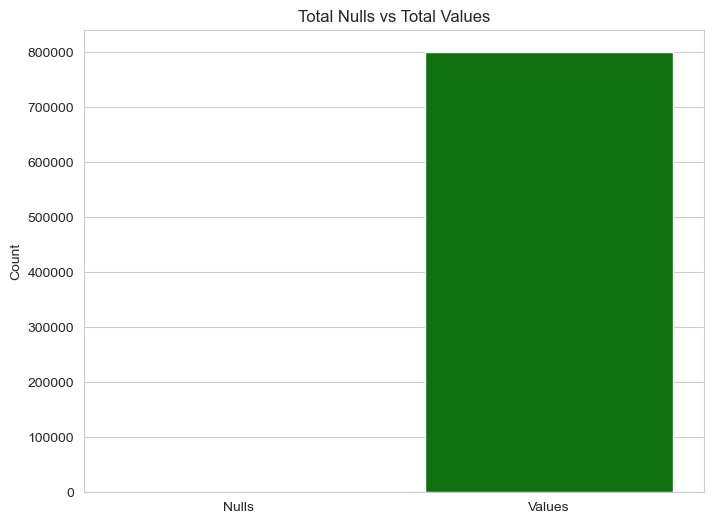

In [9]:
plotter = Plotter(df_out_rem_4_m4)

plotter.nulls_barplot()

*above* Making sure the sure the df I use for milestone 4 reall no nulls 